# Rocket Control

**Originally Contributed by**: Iain Dunning

This tutorial shows how to solve a nonlinear rocketry control problem.
The problem was drawn from the [COPS3](http://www.mcs.anl.gov/~more/cops/cops3.pdf) benchmark.

Our goal is to maximize the final altitude of a vertically launched rocket. 
We can control the thrust of the rocket, and must take account of 
the rocket mass, fuel consumption rate, gravity, and aerodynamic drag.

Let us consider the basic description of the model (for the full description, 
including parameters for the rocket, see the COPS3 PDF)

### Overview 
We will use a discretized model of time, with a fixed number of time steps, $n$. 
We will make the time step size $\Delta t$, and thus the final time $t_f = n \cdot \Delta t$, a variable in the problem. 
To approximate the derivatives in the problem we will use the [trapezoidal rule](http://en.wikipedia.org/wiki/Trapezoidal_rule).

### State and Control 
We will have three state variables:

* Velocity, $v$
* Altitude, $h$
* Mass of rocket and remaining fuel, $m$

and a single control variable, thrust $T$. 
Our goal is thus to maximize $h(t_f)$. 
Each of these corresponds to a JuMP variable indexed by the time step.

### Dynamics
We have three equations that control the dynamics of the rocket:

Rate of ascent: $$h^\prime = v$$
Acceleration: $$v^\prime = \frac{T - D(h,v)}{m} - g(h)$$
Rate of mass loss: $$m^\prime = -\frac{T}{c}$$

where drag $D(h,v)$ is a function of altitude and velocity, and gravity $g(h)$ is a function of altitude.

These forces are defined as

$$D(h,v) = D_c v^2 exp\left( -h_c \left( \frac{h-h(0)}{h(0)} \right) \right)$$
and
$$g(h) = g_0 \left( \frac{h(0)}{h} \right)^2$$

The three rate equations correspond to JuMP constraints, 
and for convenience we will represent the forces with nonlinear expressions.

In [1]:
using JuMP, Ipopt

# Create JuMP model, using Ipopt as the solver
rocket = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

# Constants
# Note that all parameters in the model have been normalized
# to be dimensionless. See the COPS3 paper for more info.
h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

T_c = 3.5  # Used for thrust
h_c = 500  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

c     = 0.5 * sqrt(g_0 * h_0)  # Thrust-to-fuel mass
m_f   = m_c * m_0            # Final mass
D_c   = 0.5 * v_c * m_0 / g_0    # Drag scaling
T_max = T_c * g_0 * m_0        # Maximum thrust

n = 800   # Time steps

@variables(rocket, begin
    Δt ≥ 0, (start = 1/n) # Time step
    # State variables
    v[1:n] ≥ 0            # Velocity
    h[1:n] ≥ h_0          # Height
    m_f ≤ m[1:n] ≤ m_0    # Mass
    # Control
    0 ≤ T[1:n] ≤ T_max    # Thrust
end)

# Objective: maximize altitude at end of time of flight
@objective(rocket, Max, h[n])

# Initial conditions
@constraints(rocket, begin
    v[1] == v_0
    h[1] == h_0
    m[1] == m_0
    m[n] == m_f
end)

# Forces
# Drag(h,v) = Dc v^2 exp( -hc * (h - h0) / h0 )
@NLexpression(rocket, drag[j = 1:n], D_c * (v[j]^2) * exp(-h_c * (h[j] - h_0) / h_0))
# Grav(h)   = go * (h0 / h)^2
@NLexpression(rocket, grav[j = 1:n], g_0 * (h_0 / h[j])^2)
# Time of flight
@NLexpression(rocket, t_f, Δt * n)

# Dynamics
for j in 2:n
    # h' = v
    
    # Rectangular integration
    # @NLconstraint(rocket, h[j] == h[j - 1] + Δt * v[j - 1])
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        h[j] == h[j - 1] + 0.5 * Δt * (v[j] + v[j - 1]))

    # v' = (T-D(h,v))/m - g(h)
    
    # Rectangular integration
    # @NLconstraint(rocket, v[j] == v[j - 1] + Δt *(
    #                 (T[j - 1] - drag[j - 1]) / m[j - 1] - grav[j - 1]))
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        v[j] == v[j-1] + 0.5 * Δt * (
            (T[j] - drag[j] - m[j] * grav[j]) / m[j] +
            (T[j - 1] - drag[j - 1] - m[j - 1] * grav[j - 1]) / m[j - 1]))

    # m' = -T/c

    # Rectangular integration
    # @NLconstraint(rocket, m[j] == m[j - 1] - Δt * T[j - 1] / c)
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        m[j] == m[j - 1] - 0.5 * Δt * (T[j] + T[j-1]) / c)
end

# Solve for the control and state
println("Solving...")
status = optimize!(rocket)

# Display results
# println("Solver status: ", status)
println("Max height: ", objective_value(rocket))

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Max height: 1.0128340648308058


In [2]:
# Can visualize the state and control variables
using Gadfly

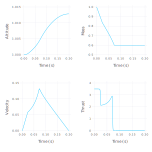

In [3]:
h_plot = plot(x = (1:n) * value.(Δt), y = value.(h)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = plot(x = (1:n) * value.(Δt), y = value.(m)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = plot(x = (1:n) * value.(Δt), y = value.(v)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = plot(x = (1:n) * value.(Δt), y = value.(T)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot, m_plot), hstack(v_plot, T_plot)))